### Connecting to the gdrive to access training data images

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Importing necessary libraries 

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
from tqdm import tqdm 
from collections import deque
from PIL import Image
import pickle as pkl
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### To unzip the datasets

In [13]:
 import os
 import matplotlib.pyplot as plt
 from PIL import Image
 import cv2
 os.chdir('/content/gdrive/My Drive/HumanMattingDatasets/')
 for file in os.listdir(os.getcwd()):
   # print(file)
   os.system('unzip ' + file)

### Total images for training

In [14]:
# start_id = '00000000'
# end_id = '00000010'

feat_img_dir = '/content/gdrive/My Drive/HumanMattingDatasets/matting/1803151818/matting_000000'
i = 0
for x in range(21):
  folder_num = str(x).zfill(2)
  folder = feat_img_dir + folder_num + '/'
  j = 0
  for file in os.listdir(folder):
    j += 1
  # print(j)
  i += j

print('total', i)


total 9215


## Creating an Image dataset for feature Image & target Image

It loads all the images from the folder in the gdrive and then converts each image to 128x128 image pixel and then convert the image to a tensor of range 0 to 1. It also attaches to the device available (Cpu or Cuda). 

In [15]:
class ImageDatasets(Dataset):
  def __init__(self, transform=None, device=None, root='/content/gdrive/My Drive/HumanMattingDatasets/'):
    self.root = root
    self.feat_img_path = self.root + 'clip_img/1803151818/'
    self.target_img_path = self.root + 'matting/1803151818/'
    self.transform = transform
    self.device = device 
    self.ft_imgs = self.load_images(self.feat_img_path)
    self.tar_imgs = self.load_images(self.target_img_path)

  def __len__(self):
    if (len(self.ft_imgs) == len(self.tar_imgs)):
      return len(self.ft_imgs)

    else:
      return 0

  def __getitem__(self, index):
    ft = self.ft_imgs[index]
    tar = self.tar_imgs[index]

    feat_img = Image.open(ft)
    target_img = Image.open(tar)

    if self.transform:
      feat_img = self.transform(feat_img)
      target_img = self.transform(target_img)
    
    # feat_img = self.scale(feat_img)
    # target_img = self.scale(target_img)

    return feat_img.to(self.device), target_img.to(self.device)

  def scale(self, x, feature_range=(-1, 1)):
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

  def load_images(self, path):
    img_path = []
    fid = 0
    for folder in sorted(os.listdir(path)):
      fid = folder.split('_')[1]
      if(int(fid) > 20):
        break
      for file in sorted(os.listdir(path + folder)):
        img_path.append(path + folder + '/' + file)

    return img_path

In [16]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])

In [17]:
dataset = ImageDatasets(transform, device=device)
f, t = dataset[5]

print(f.shape, t.shape, len(dataset))

torch.Size([3, 128, 128]) torch.Size([4, 128, 128]) 9215


## Splitting the dataset for training, validation and test purposes

In [18]:
split = 0.8
dataset_size = len(dataset)
indices = list(range(dataset_size))
train_indices = indices[ : int(dataset_size*split)]
val_indices = indices[int(dataset_size*split) : dataset_size-int(dataset_size*0.1)]
test_indices = indices[dataset_size-int(dataset_size*0.1) :]

print(len(train_indices), len(val_indices), len(test_indices))

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

7372 922 921


## Creating dataloader

In [19]:
trainLoader = torch.utils.data.DataLoader(dataset, batch_size=8, sampler=train_sampler)
valLoader = torch.utils.data.DataLoader(dataset, batch_size=16, sampler=valid_sampler)
testLoader = torch.utils.data.DataLoader(dataset, batch_size=16, sampler=test_sampler)

## Checking our dataloader to produce correct pair of feature & target Images and extract segmented map of the image.



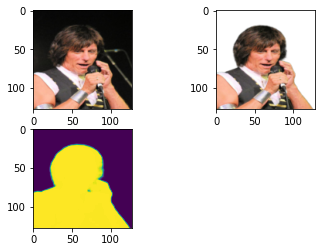

In [20]:
a = iter(trainLoader)
f, t = next(a)
feat = f[5].cpu()
tar = t[5].cpu()
i1 = torchvision.transforms.ToPILImage()(feat)
i2 = torchvision.transforms.ToPILImage()(tar)
fig = plt.figure()
a1 = fig.add_subplot(221)
a1.imshow(i1)
a2 = fig.add_subplot(222)
a2.imshow(i2)

r, g, b, gr = i2.split()
a3 = fig.add_subplot(223)
a3.imshow(gr)

plt.show()

# Architecture for our Auto-encoder based model - Wave U net model
The model takes a rgb image of 128x128 pixels. It then goes though **in_conv** layer - which is 2 convolutional layer. 

Later, it goes through **3 down_sample** layers - which is a maxpooling layer followed by a in_conv layer(2 convolutional layer). 

Once the encoder part is done, the model moves to the decoder part. In it, the output of the encoder is presented to a deconvlutional layer(**up_sample_conv**) which is merged with the parallel layer(**concat**) in the encoder - Once merged, two convolutions(**in_conv**) are performed. 
This process is continued for 3 iterations. 

The output of the model is a 4 channel image of 128x128 pixel with the 4th channel being the segmented map of the image and other three being the rgb channels.

All the layers have relu activation functions applied to them except for the last layer which has a tanh function since we want the outputs to be in the range of -1 to 1(same as out input). 


In [25]:
class Generator(nn.Module):
  def __init__(self, conv_dims=32):
    super(Generator, self).__init__()
    self.seed = 42

    self.layers_in = nn.Sequential(

        nn.Conv2d(3, 32, 3, padding=1, bias = False),
        nn.BatchNorm2d(32),
        #nn.ReLU(inplace=True),
        nn.Conv2d(32, 32, 3, padding=1, bias = False),
        nn.BatchNorm2d(32),
        
    )

    self.layers_down1 = nn.Sequential(
        # 0.167, 0.333, 0.5
        nn.MaxPool2d(2,stride = 2, padding= 0),

        nn.Conv2d(32, 37, 3, padding=1, bias = False),
        nn.BatchNorm2d(37),
        nn.ReLU(inplace=True),
        nn.Conv2d(37, 48, 3, padding=1, bias=False),
        nn.BatchNorm2d(48),
        nn.ReLU(inplace=True),
        nn.Conv2d(48, 64, 3, padding=1, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 3, padding=1, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True)
    )

    self.layers_down2 = nn.Sequential(
        # 0.167, 0.333, 0.5
        nn.MaxPool2d(2,stride = 2, padding= 0),

        nn.Conv2d(64, 75, 3, padding=1, bias = False),
        nn.BatchNorm2d(75),
        nn.ReLU(inplace=True), 
        nn.Conv2d(75, 96, 3, padding=1, bias = False),
        nn.BatchNorm2d(96),
        nn.ReLU(inplace=True), 
        nn.Conv2d(96, 128, 3, padding=1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True), 
        nn.Conv2d(128, 128, 3, padding=1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
     )

    self.layers_down3 = nn.Sequential(
        # 0.167, 0.333, 0.5
        nn.MaxPool2d(2,stride = 2, padding= 0),

        nn.Conv2d(128, 149, 3, padding=1, bias = False),
        nn.BatchNorm2d(149),
        nn.ReLU(inplace=True),    
        nn.Conv2d(149, 192, 3, padding=1, bias = False),
        nn.BatchNorm2d(192),
        nn.ReLU(inplace=True),   
        nn.Conv2d(192, 256, 3, padding=1, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),   
        nn.Conv2d(256, 256, 3, padding=1, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True)
    )

    self.layers_down4 = nn.Sequential(
        # 0.167, 0.333, 0.5
        nn.MaxPool2d(2,stride = 2, padding= 0),

        nn.Conv2d(256, 299, 3, padding=1, bias = False),
        nn.BatchNorm2d(299),
        nn.ReLU(inplace=True),
        nn.Conv2d(299, 384, 3, padding=1, bias = False),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 512, 3, padding=1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, 3, padding=1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
     )
    self.layers_up1s = nn.Sequential(
        #nn.Upsample(scale_factor=2),
        nn.ConvTranspose2d(512, 256, 4, stride = 2, padding=1, bias = False),
        nn.BatchNorm2d(256),
        #nn.ReLU(inplace=True),        

    )
    self.layers_up1c = nn.Sequential(   
        nn.Conv2d(512, 256, 3, padding=1, bias = False),
        nn.BatchNorm2d(256),
        #nn.ReLU(inplace=True),
        
        nn.Conv2d(256, 256, 3, padding=1, bias = False),
        nn.BatchNorm2d(256),
        #nn.ReLU(inplace=True),
    )
    self.layers_up2s = nn.Sequential(   
        #nn.Upsample(scale_factor =2),
        nn.ConvTranspose2d(256, 128, 4, stride = 2, padding=1, bias = False),
        nn.BatchNorm2d(128),
        #nn.ReLU(inplace=True),
    )
    self.layers_up2c = nn.Sequential(   
        nn.Conv2d(256, 128, 3, padding=1, bias = False),
        nn.BatchNorm2d(128),
        #nn.ReLU(inplace=True),
        
        nn.Conv2d(128, 128, 3, padding=1, bias = False),
        nn.BatchNorm2d(128),
        #nn.ReLU(inplace=True),
    )
    self.layers_up3s = nn.Sequential(
        #nn.Upsample(scale_factor=2),
        nn.ConvTranspose2d(128, 64, 4, stride = 2, padding=1, bias = False),
        nn.BatchNorm2d(64),
        #nn.ReLU(inplace=True),
    )
    self.layers_up3c = nn.Sequential(  
        nn.Conv2d(128, 64, 3, padding=1, bias = False),
        nn.BatchNorm2d(64),
        #nn.ReLU(inplace=True),  
        
        nn.Conv2d(64, 64, 3, padding=1, bias = False),
        nn.BatchNorm2d(64),
        #nn.ReLU(inplace=True),
    )

    self.layers_up4s = nn.Sequential(
        #nn.Upsample(scale_factor=2),
        nn.ConvTranspose2d(64, 32, 4, stride = 2, padding=1, bias = False),
        nn.BatchNorm2d(32),
        #nn.ReLU(inplace=True),
    )
    self.layers_up4c = nn.Sequential(  
        nn.Conv2d(64, 32, 3, padding=1, bias = False),
        nn.BatchNorm2d(32),
        #nn.ReLU(inplace=True),  
        
        nn.Conv2d(32, 32, 3, padding=1, bias = False),
        nn.BatchNorm2d(32),
        #nn.ReLU(inplace=True),
    )

    self.layers_out = nn.Sequential(  
        nn.Conv2d(32, 4, 3, padding=1, bias = False),
        nn.BatchNorm2d(4),
        nn.Conv2d(4, 4, 3, padding=1, bias = False),
        #nn.ReLU(inplace=True),
    )
     


    ## input 3x128x128
    # self.in_layer = in_conv(3, conv_dims, True) ## 32x128x128

    # self.down_samp_conv1 = down_samp_conv(conv_dims, conv_dims*2, True) ## 64x64x64
    # self.down_samp_conv2 = down_samp_conv(conv_dims*2, conv_dims*4, True) ## 128x32x32
    # self.down_samp_conv3 = down_samp_conv(conv_dims*4, conv_dims*8, True) ## 256x16x16

    # self.up_samp_conv1 = up_samp_conv(conv_dims*8, conv_dims*4, True)  ## 128x32x32
    # self.up_concat_conv1 = in_conv(conv_dims*8, conv_dims*4, True)
    # self.up_samp_conv2 = up_samp_conv(conv_dims*4, conv_dims*2, True) ## 64x64x64
    # self.up_concat_conv2 = in_conv(conv_dims*4, conv_dims*2, True)
    # self.up_samp_conv3 = up_samp_conv(conv_dims*2, conv_dims, True) ## 32x128x128
    # self.up_concat_conv3 = in_conv(conv_dims*2, conv_dims, True)

    # self.out_layer = nn.Sequential(*[conv(conv_dims, 4, batchNorm=True),
    #                                  conv(4, 4)])
    
    # in_conv(conv_dims, 4)

  def forward(self, x):
    ## Input size 3x128x128
    x_in = F.relu(self.layers_in(x)) #32x128x128
    x_down1 = F.relu(self.layers_down1(x_in)) #64x64x64
    x_down2 = F.relu(self.layers_down2(x_down1)) #128x32x32
    x_down3 = F.relu(self.layers_down3(x_down2)) #256x16x16
    x_down4 = self.layers_down4(x_down3) #512x8x8

    x_up1 = self.layers_up1s(x_down4) #256x16x16 
    x_up1c = torch.cat([x_up1, x_down3], dim=1) #512x16x16
    x_up1 = self.layers_up1c(x_up1c) #256x16x16

    x_up2 = F.relu(self.layers_up2s(x_down3)) #128x32x32
    x_up2c = torch.cat([x_up2, x_down2], dim=1) #128x32x32
    x_up2 = F.relu(self.layers_up2c(x_up2c)) #128x32x32

    x_up3 = F.relu(self.layers_up3s(x_up2)) #64x64x64
    x_up3c = torch.cat([x_up3, x_down1], dim=1)
    x_up3 = F.relu(self.layers_up3c(x_up3c))

    x_up4 = F.relu(self.layers_up4s(x_up3))
    x_up4c = torch.cat([x_up4, x_in], dim=1)
    x_up4 = F.relu(self.layers_up4c(x_up4c))

    x_o = torch.tanh(self.layers_out(x_up4))



    # l1 = F.relu(self.in_layer(x)) ## 32x128x128
    # d_l2 = F.relu(self.down_samp_conv1(l1)) ## 64x64x64
    # d_l3 = F.relu(self.down_samp_conv2(d_l2)) ## 128x32x32
    # d_l4 = F.relu(self.down_samp_conv3(d_l3)) ## 256x16x16

    # up_l1 = F.relu(self.up_samp_conv1(d_l4)) ## 128x32x32
    # up_l1_concat = torch.cat([up_l1, d_l3], dim=1) ## 256x32x32
    # up_l1 = F.relu(self.up_concat_conv1(up_l1_concat))  ## 128x32x32

    # up_l2 = F.relu(self.up_samp_conv2(up_l1)) ## 64x64x64
    # up_l2_concat = torch.cat([up_l2, d_l2], dim=1) ## 128x64x64
    # up_l2 = F.relu(self.up_concat_conv2(up_l2_concat))  ## 64x64x64

    # up_l3 = F.relu(self.up_samp_conv3(up_l2)) ## 32x128x128
    # up_l3_concat = torch.cat([up_l3, l1], dim=1) ## 64x128x128
    # up_l3 = F.relu(self.up_concat_conv3(up_l3_concat))  ## 32x128x128

    # out_layer = torch.tanh(self.out_layer(up_l3)) ## 4x128x128

    return x_o


In [26]:
name = 'starter_net'
net = Generator().to(device)
# visualizing the model
print('Your network:')
summary(net, (3,128,128))

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
            Conv2d-3         [-1, 32, 128, 128]           9,216
       BatchNorm2d-4         [-1, 32, 128, 128]              64
         MaxPool2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 37, 64, 64]          10,656
       BatchNorm2d-7           [-1, 37, 64, 64]              74
              ReLU-8           [-1, 37, 64, 64]               0
            Conv2d-9           [-1, 48, 64, 64]          15,984
      BatchNorm2d-10           [-1, 48, 64, 64]              96
             ReLU-11           [-1, 48, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          27,648
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14     

In [27]:
G= Generator()
G = G.to(device)
# D = D.to(device)
#G.load_state_dict(torch.load('/content/gdrive/My Drive/HumanMattingDatasets/img_matting_checkpoint_G_3.pth'))

In [28]:
G

Generator(
  (layers_in): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layers_down1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(32, 37, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(37, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

### Function to preview the results
Converts the tensor from -1to1 range to pixel values of 128x128

In [29]:
def view_results(fimg, num_img=8, index=1):
    
  fig, axes = plt.subplots(figsize=(16,10), nrows=1, ncols=num_img, sharey=True, sharex=True)
  for ax, fimg in zip(axes.flatten(), fimg):
    fimg = fimg.detach().cpu().numpy()
    fimg = np.transpose(fimg, (1, 2, 0))
    fimg = ((fimg +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
    # print(min(img), max(img))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(fimg.reshape((128,128,3 + index)))

  plt.show()

### Scale function to convert tensors from range 0 and 1 to -1 and 1. 

In [30]:
def scale(x, feature_range=(-1, 1)):
  # scale from 0-1 to feature_range
  min, max = feature_range
  x = x * (max - min) + min
  return x

### Learnable parameters 
I also tried with lr = 0.01 which was pretty good at first but at later stages the model was experiencing huge losses - missing of the minima. 

In [31]:
# hyperparams for Adam optimizers
lr= 0.0002
beta1= 0.5
beta2= 0.9
print_every = 10
losses = []
val_losses = []
samples = []
act_samples = []

# Create optimizers for the generators and discriminators
criterion = nn.MSELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr, [beta1, beta2])
#d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])

### Training Loop
You can also print the images as we train - since I was training in colab, it used to hung up. That's why I had to comment that and started training without the samples to be printed after every iterations. 

If you want to train it using cycleGAN approach, you need to add few lines to check the generator response to feature images and then calculate loss function accordingly. 
Contact me if you need help with that. 

In [32]:
def training_loop(trainLoader, valLoader, n_epochs=2000):
  min_loss = 100000.00

  iter_train_img = iter(trainLoader)
  iter_val_img = iter(valLoader)
  train_loss_deque = deque(maxlen=10)
  # val_fixed_feat, val_fixed_tar = next(val_iter)

  # act_samples.append(val_fixed_tar)
  
  batches_per_epochs_train = len(trainLoader)
  batches_per_epochs_val = len(valLoader)
  for epoch in (range(n_epochs)):
    # print('Epoch [{:5d}/{:5d}]'.format(epoch, n_epochs))
    if epoch % batches_per_epochs_train == 0:
      iter_train_img = iter(trainLoader)

    feat_img, tar_img = next(iter_train_img)
    feat_img = scale(feat_img)
    tar_img = scale(tar_img)

    ## Generator
    g_optimizer.zero_grad()
    fake_img = G(feat_img)
    g_loss = criterion(fake_img, tar_img)
    g_loss.backward()
    g_optimizer.step()

    # G.eval() # for generating samples
    # with torch.no_grad():
    #   samples_z = G(val_fixed_feat)
    #   samples.append(samples_z)
    #   view_samples(-1, samples)
    #   view_samples(-1, act_samples)
    # G.train() # back to training mode

    train_loss_deque.append(g_loss.item())

    if epoch % print_every == 0:
      if (epoch % batches_per_epochs_val == 0) or (epoch > batches_per_epochs_val):
        iter_val_img = iter(valLoader)

      G.eval()
      with torch.no_grad():
        val_feat, val_tar = next(iter_val_img)
        val_feat = scale(val_feat)
        val_tar = scale(val_tar)

        fake_val_img = G(val_feat)
        val_loss = criterion(fake_val_img, val_tar)
      G.train()

      val_losses.append(val_loss.item())
      losses.append(np.mean(train_loss_deque))
      print('Epoch [{:5d}/{:5d}] | g_training_loss: {:6.4f} | g_validation_loss: {:6.4f}'.format(
              epoch, n_epochs, np.mean(train_loss_deque), val_loss.item()))
      
      if np.mean(train_loss_deque) < min_loss :
        min_loss = np.mean(train_loss_deque)
        print('saving data ..  g_total_loss: {:6.4f} '.format(np.mean(train_loss_deque)))
        #torch.save(G.state_dict(), '/content/gdrive/My Drive/HumanMattingDatasets/img_matting_checkpoint_G_3.pth')
        # torch.save(D.state_dict(), '/content/gdrive/My Drive/HumanMattingDatasets/img_matting_checkpoint_D.pth')

        # pkl_file = open('/content/gdrive/My Drive/HumanMattingDatasets/img_matting_train_samples.pkl', 'wb')
        # pkl.dump(samples, pkl_file)
        # pkl_file.close()


In [33]:
training_loop(trainLoader, valLoader, n_epochs=120)

Epoch [    0/  120] | g_training_loss: 0.8047 | g_validation_loss: 0.6972
saving data ..  g_total_loss: 0.8047 
Epoch [   10/  120] | g_training_loss: 0.5453 | g_validation_loss: 0.6649
saving data ..  g_total_loss: 0.5453 
Epoch [   20/  120] | g_training_loss: 0.3785 | g_validation_loss: 0.6140
saving data ..  g_total_loss: 0.3785 
Epoch [   30/  120] | g_training_loss: 0.3538 | g_validation_loss: 0.6350
saving data ..  g_total_loss: 0.3538 
Epoch [   40/  120] | g_training_loss: 0.3571 | g_validation_loss: 0.2962
Epoch [   50/  120] | g_training_loss: 0.2957 | g_validation_loss: 0.3074
saving data ..  g_total_loss: 0.2957 
Epoch [   60/  120] | g_training_loss: 0.2838 | g_validation_loss: 0.3153
saving data ..  g_total_loss: 0.2838 
Epoch [   70/  120] | g_training_loss: 0.2992 | g_validation_loss: 0.2942
Epoch [   80/  120] | g_training_loss: 0.2412 | g_validation_loss: 0.2849
saving data ..  g_total_loss: 0.2412 
Epoch [   90/  120] | g_training_loss: 0.2387 | g_validation_loss: 0

## Loss function with vanilla MSE

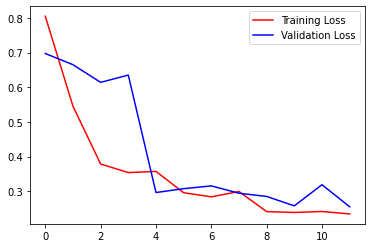

In [34]:
y = np.arange(len(losses))
plt.plot(y, losses, 'r', label='Training Loss')
plt.plot(y, val_losses, 'b', label="Validation Loss")
plt.legend(loc='best')
plt.show()

In [35]:
pkl_file = open('/content/gdrive/My Drive/HumanMattingDatasets/img_matting_losses_train_val.pkl', 'wb')
pkl.dump((losses, val_losses), pkl_file)
pkl_file.close()

OSError: ignored

## Loss function with MSE Loss with sum reduction
I trained the model for about 6000 epochs, but the there were not dratic change in the loss value. But rather a flattenning can be observed. So, that's why I stopped the training after that. 

In [26]:
y = np.arange(len(prev_loss))
plt.plot(y, prev_loss, label='Training Loss')
plt.xlabel('After every 10 epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

NameError: ignored

## Results after partial training

## Testing validation data on the model - with vanilla MSE 

					 Actual Images 				 	


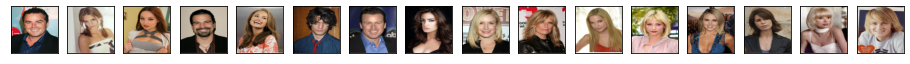

In [ ]:
a = iter(valLoader)
f, t = next(a)
f = scale(f)
t = scale(t)
print("\t\t\t\t\t Actual Images \t\t\t\t \t")
view_results(f, num_img=16, index=0)

					 Actual Segemented Images 				 	


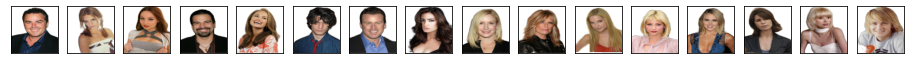

					 Model's Segmented Images 				 	


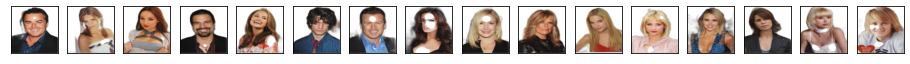

In [ ]:
out = G(f)
print("\t\t\t\t\t Actual Segemented Images \t\t\t\t \t")
view_results(t, num_img=16)
print("\t\t\t\t\t Model's Segmented Images \t\t\t\t \t")
view_results(out, num_img=16)

## Testing validation data on the model - with MSE loss with sum reduction

					 Actual Images 				 	


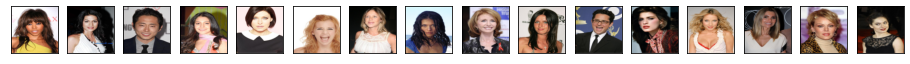

In [ ]:
a = iter(valLoader)
f, t = next(a)
f = scale(f)
t = scale(t)
print("\t\t\t\t\t Actual Images \t\t\t\t \t")
view_results(f, num_img=16, index=0)

					 Actual Segemented Images 				 	


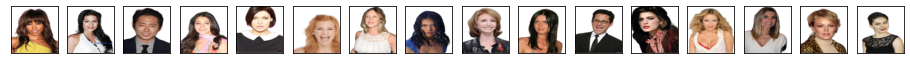

					 Model's Segmented Images 				 	


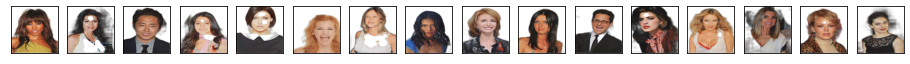

In [ ]:
out = G(f)
print("\t\t\t\t\t Actual Segemented Images \t\t\t\t \t")
view_results(t, num_img=16)
print("\t\t\t\t\t Model's Segmented Images \t\t\t\t \t")
view_results(out, num_img=16)

## Testing test data on the model - with MSE loss with sum reduction

					 Actual Images 				 	


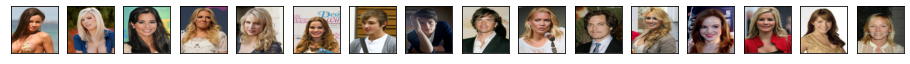

In [ ]:
test = iter(testLoader)
ft, tt = next(test)
f = scale(ft)
t = scale(tt)
print("\t\t\t\t\t Actual Images \t\t\t\t \t")
view_results(f, num_img=16, index=0)

					 Actual Segmented Images 				 	


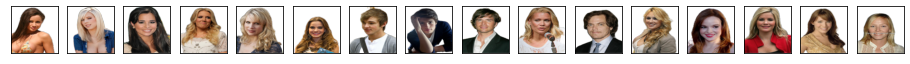

					 Model's Segmented Images 				 	


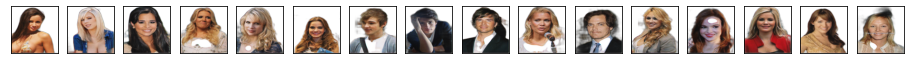

In [ ]:
out = G(f)
print("\t\t\t\t\t Actual Segmented Images \t\t\t\t \t")
view_results(t, num_img=16)
print("\t\t\t\t\t Model's Segmented Images \t\t\t\t \t")
view_results(out, num_img=16)

### Loss functions for CycleGAN
Use these loss functions if you want to train the model using cycleGAN approach. 

In [ ]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "false"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss

In [ ]:
def view_samples(epoch, samples, index=1):
  fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=8, sharey=True, sharex=True)
  for ax, fimg in zip(axes.flatten(), samples[epoch]):
    fimg = fimg.detach().cpu().numpy()
    fimg = np.transpose(fimg, (1, 2, 0))
    fimg = ((fimg +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
    # print(min(img), max(img))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(fimg.reshape((128,128,3 + index)))

  plt.show()